# PixieApp for Outlier Detection
### Demonstrated with a Boston Public Schools data set
 

PixieApps from the PixieDust package are a great tool to facilitate data exploration. The PixieApp for outlier detection can currently run two unsupervised machine learning models and visualize their output. It's a work in progress, and the goal is also to make it more flexible to fit the needs of different data types.

The next step after this notebook will be to allow users to interact more with the output and to tune the outlier algorithms inside the PixieApp.

This notebook uses a data set composed of facility and administrative information for Boston Public Schools (BPS) from <a href="https://data.boston.gov" target="_blank" rel="noopener no referrer">Analyze Boston</a> to answer these two questions:

1. What is the relationship between square footage of a school, enrollment, location, and energy costs? <br/>
Can we predict how much a school will pay in energy costs with facility data?

2. How often do Principals live in the zip code of their school? 
Can we predict how far from a school the principal will live using demographic information for zip codes and principal total earnings?

This notebook runs on Python with Spark 2.1.

## Table of contents
1. [Install PixieDust](#install)
2. [Create the Boston Public Schools data set](#createdataset)
3. [Create the PixieApp](#createpixieapp)
4. [Run the PixieApp](#runpixieapp)
5. [Explore data in two-dimensions](#explore)
6. [Next steps](#nextsteps)


## 1. Install PixieDust<a class="anchor" id="install"></a>

First, make sure PixieDust and scikit-learn are up-to-date.

In [1]:
!pip install --user --upgrade pixiedust
!pip install --user --upgrade scikit-learn

Requirement already up-to-date: pixiedust in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s778-bfb6f75aebc10f-9bb95b1f072f/.local/lib/python2.7/site-packages
Requirement already up-to-date: mpld3 in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s778-bfb6f75aebc10f-9bb95b1f072f/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: lxml in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s778-bfb6f75aebc10f-9bb95b1f072f/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: geojson in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s778-bfb6f75aebc10f-9bb95b1f072f/.local/lib/python2.7/site-packages (from pixiedust)
Requirement already up-to-date: scikit-learn in /gpfs/global_fs01/sym_shared/YPProdSpark/user/s778-bfb6f75aebc10f-9bb95b1f072f/.local/lib/python2.7/site-packages


In [2]:
import pixiedust
import numpy as np
import matplotlib.pyplot as plt
import sklearn.ensemble
import pandas as pd
from sklearn import svm
from pyspark.mllib.stat import Statistics
from pyspark.mllib.clustering import *
import pyspark.sql.functions as fn
from re import sub
from decimal import Decimal



Pixiedust database opened successfully


## 2. Create the Boston Public Schools data set<a class="anchor" id="createdataset"></a>

2.1 [Import the BuildBPS data set](#buildbps)<br/>
2.2 [Link BuildBPS data set to the Employee Earnings data set](#linkdataset)<br/>
2.3 [Merge the employee information with the school data set](#merge)<br/>
2.4 [Format variables](#formatvar)


### 2.1 Import the BuildBPS data set<a class="anchor" id="buildbps"></a>

The backbone of the Boston Public Schools (BPS) data set, BuildBPS, includes:

- Latitude and longitude for schools in BPS
- Energy costs
- Facility information 
- Enrollment information 
- Administration information 

Principal name is separated into first and last name to link to the Employee Earnings data set.

In [3]:
#Import the data and transform to Pandas. Pixiedust works with Spark dataframes, but unfortunately, scikitlearn will not.
schools = pixiedust.sampleData("https://data.boston.gov/dataset/b2c5a9d3-609d-49ec-906c-b0e850a8d62a/resource/33c5f44a-3c67-4390-a1d5-1bf018e4728c/download/buildbps.csv")
schools = schools.toPandas()

#Pull a subset of variables of interest
schools = schools[['SMMA_Identifier', 'BPS_School_Name', 'BPS_Address', 'SMMA_latitude', 'SMMA_longitude', 'BPS_Grades_Offered', 'SMMA_Site_SF', 'DOE_Total', ' BPS_Total_Energy_Cost ', 'BPS_Principal']]

#Separate the principals' first and last names to aid linking
def findFirstName(name):
    if isinstance(name, basestring):
        if 'Dr' in name:
            name = name.split('. ')[-1]
        firstname = name.split(' ')[0]
    else:
        firstname = name
    return firstname

schools['Principal_Firstname'] = schools['BPS_Principal'].apply(lambda x : findFirstName(x))

def findLastName(name):
#takes the last word before an optional comma, which should be the last name in this dataset
    if isinstance(name, basestring):
        name = name.split(',')[0]
        if isinstance(name, basestring):
            lastname = name.split(' ')[-1]
            if lastname == 'Jr.':
                lastname = name.split(' ')[-2]
        else:
            lastname = name
    else:
        lastname = name
    return lastname

schools['Principal_Lastname'] = schools['BPS_Principal'].apply(lambda x : findLastName(x))

#Print the first 5 rows to get a look at the data
schools.head()

Downloaded 175213 bytes
Creating pySpark DataFrame for 'https://data.boston.gov/dataset/b2c5a9d3-609d-49ec-906c-b0e850a8d62a/resource/33c5f44a-3c67-4390-a1d5-1bf018e4728c/download/buildbps.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://data.boston.gov/dataset/b2c5a9d3-609d-49ec-906c-b0e850a8d62a/resource/33c5f44a-3c67-4390-a1d5-1bf018e4728c/download/buildbps.csv'


,SMMA_Identifier,BPS_School_Name,BPS_Address,SMMA_latitude,SMMA_longitude,BPS_Grades_Offered,SMMA_Site_SF,DOE_Total,BPS_Total_Energy_Cost,BPS_Principal,Principal_Firstname,Principal_Lastname
0,031,"Adams, Samuel Elementary","165 Webster St East Boston, MA 02128",42.365553,-71.034917,K0-5,40680,302,"$71,740.00",Hannah Irvin,Hannah,Irvin
1,078,"Alighieri, Dante Montessori School","37 Gove Street East Boston, MA 02128",42.371565,-71.037608,K0-5,22039,90,"$13,714.00",Mayra Cuevas,Mayra,Cuevas
2,045A,Another Course to College*,"20 Warren Street Brighton, MA 02135",42.350354,-71.145582,9-12,83088,237,"$128,398.00",Lisa Gilbert-Smith,Lisa,Gilbert-Smith
3,012,Baldwin Early Learning Pilot Academy,"121 Corey Rd Brighton, MA 02135",42.342037,-71.140529,K0-1,29990,142,"$26,472.00",Tavia Mead,Tavia,Mead
4,087,"Bates, Phineas Elementary","426 Beech St Roslindale, MA 02131",42.277663,-71.135353,K1-5,67077,297,"$35,538.00",Kelly Hung,Kelly,Hung


### 2.2 Link BuildBPS to the Employee Earnings data set<a class="anchor" id="linkdataset"></a>

To make it more interesting, link the BuildBPS data set to get *principal earnings* and *zip code* from the Employee Earnings data set. Because principal name is the only available linking variable, this gets a bit messy. <br/>
This data set includes:
- Employee names
- Departments
- Titles
- Earnings
- Zip code

In [4]:
#Import the data and transform to Pandas
employees = pixiedust.sampleData("https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/2ff6343f-850d-46e7-98d1-aca79b619fd6/download/employee-earnings-report-2015.csv")
employees = employees.toPandas()

#Keep variables of interest
employees = employees[['NAME', 'DEPARTMENT_NAME', 'TITLE', 'TOTAL EARNINGS', 'POSTAL']]

#Keep employees with title containing "headmaster" or "principal"
employees = employees[employees['TITLE'].str.contains('headmaster|principal', case = False)]

#Separate first and last names for merging with the key dataset
employees['Principal_Lastname'] = employees['NAME'].str.split(',', 1, expand = True)[0]
employees['Principal_Firstname'] = employees['NAME'].str.split(',', 1, expand = True)[1]

#Print the first 5 rows to get a look at the data
employees.head()

Downloaded 2712454 bytes
Creating pySpark DataFrame for 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/2ff6343f-850d-46e7-98d1-aca79b619fd6/download/employee-earnings-report-2015.csv'. Please wait...
Loading file using 'SparkSession'
Successfully created pySpark DataFrame for 'https://data.boston.gov/dataset/418983dc-7cae-42bb-88e4-d56f5adcf869/resource/2ff6343f-850d-46e7-98d1-aca79b619fd6/download/employee-earnings-report-2015.csv'


,NAME,DEPARTMENT_NAME,TITLE,TOTAL EARNINGS,POSTAL,Principal_Lastname,Principal_Firstname
156,"Ake,Natalie Diaz",Ellison/Parks EES,Principal Elementary,$123698.49,02131,Ake,Natalie Diaz
529,"Anoh,Jean-Dominique H.",Lyon Pilot High 9-12,Headmaster,$129688.40,01721,Anoh,Jean-Dominique H.
793,"Azores,Sheila M",BPS Alternative Education HS,Headmaster,$135919.81,02126,Azores,Sheila M
801,"Babio,Phanenca",BPS MPH\Health Academy,Asst Headmaster,$73619.11,02124,Babio,Phanenca
1193,"Becker,Jeffrey Brian",Green Academy,Asst Headmaster,$97950.42,02176,Becker,Jeffrey Brian


### 2.3 Merge the employee information with the school data set<a class="anchor" id="merge"></a>

Next, merge the employee information into the school data set. First names differ slightly and nicknames are sometimes used (for example, "Rob" vs. "Robert"), so we match on last name and first three letters of first name.

To make this more accurate in the future, consider using a fuzzy matching algorithm. 40 schools (about 30% of the data set) are lost in the matching, either due to missing principal name in the BuildBPS data set (11) or inadequate matching (29). 

In [5]:
#Merge on last name
schools_df = pd.merge(schools, employees, on = 'Principal_Lastname')

#Keep those matches that match in the first 3 letters of first name
schools_df['Firstname_match'] = schools_df['Principal_Firstname_x'].apply(lambda x : x[0:3].lower())
schools_df['Principal_Firstname_y'] = schools_df['Principal_Firstname_y'].apply(lambda x: x.lower())
schools_df['correct_name'] = schools_df.apply(lambda x: x['Firstname_match'] in x['Principal_Firstname_y'], axis = 1)
schools_df = schools_df[schools_df['correct_name']]

schools_df.describe(include = 'all')

,SMMA_Identifier,BPS_School_Name,BPS_Address,SMMA_latitude,SMMA_longitude,BPS_Grades_Offered,SMMA_Site_SF,DOE_Total,BPS_Total_Energy_Cost,BPS_Principal,Principal_Firstname_x,Principal_Lastname,NAME,DEPARTMENT_NAME,TITLE,TOTAL EARNINGS,POSTAL,Principal_Firstname_y,Firstname_match,correct_name
count,98,98,98,98.000000,98.000000,98,97.000000,98,98,98,98,98,98,98,98,98,98,98,98,98
unique,98,98,95,NaN,NaN,26,NaN,89,91,95,93,95,95,95,4,92,49,95,76,NaN
top,124,"Guild, Curtis Elementary","40 Armington St Allston, MA 02134",NaN,NaN,9-12,NaN,302,$-,Simon Ho,Simon,Sheridan,"Ho,Simon S",Warren/Prescott K-8,Principal Elementary,$135338.96,02131,simon s,mar,NaN
freq,1,1,2,NaN,NaN,18,NaN,3,4,2,2,2,2,2,45,2,8,2,5,NaN
mean,NaN,NaN,NaN,42.321021,-71.090898,NaN,149100.247423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
std,NaN,NaN,NaN,0.037020,0.037956,NaN,250486.793801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
min,NaN,NaN,NaN,42.233938,-71.174549,NaN,5328.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
25%,NaN,NaN,NaN,42.288235,-71.117920,NaN,49940.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
50%,NaN,NaN,NaN,42.325601,-71.089480,NaN,73819.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
75%,NaN,NaN,NaN,42.347923,-71.064721,NaN,152690.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


### 2. 4 Format variables<a class="anchor" id="formatvar"></a>

Some numeric variables, like earnings and energy cost, are saved as string and need to be converted to numeric.

In [6]:
#Remove schools with missing energy cost (4 schools)
schools_df['no_energy_cost'] = schools_df.apply(lambda x: '-' in x[' BPS_Total_Energy_Cost '], axis = 1)
schools_df = schools_df[~schools_df['no_energy_cost']]

#Restore numeric fields stored as strings to their former glory
schools_df[' BPS_Total_Energy_Cost '] = schools_df[' BPS_Total_Energy_Cost '].apply(lambda x: float(sub(r'[^\d.]', '', x)))
schools_df['TOTAL EARNINGS'] = schools_df['TOTAL EARNINGS'].apply(lambda x: float(sub(r'[^\d.]', '', x)))
schools_df['DOE_Total'] = schools_df['DOE_Total'].apply(lambda x: int(x))

#Drop intermediate linking and boolean fields
schools_df = schools_df[['SMMA_Identifier', 'BPS_School_Name', 'BPS_Address', 'SMMA_latitude', 'SMMA_longitude', 'BPS_Grades_Offered', 'SMMA_Site_SF', 'DOE_Total', ' BPS_Total_Energy_Cost ', 'BPS_Principal', 'TOTAL EARNINGS', 'POSTAL', 'TITLE']]

#Summary statistics:
schools_df.describe(include = 'all')

,SMMA_Identifier,BPS_School_Name,BPS_Address,SMMA_latitude,SMMA_longitude,BPS_Grades_Offered,SMMA_Site_SF,DOE_Total,BPS_Total_Energy_Cost,BPS_Principal,TOTAL EARNINGS,POSTAL,TITLE
count,94,94,94,94.000000,94.000000,94,93.000000,94.000000,94.000000,94,94.000000,94,94
unique,94,94,91,NaN,NaN,25,NaN,NaN,NaN,91,NaN,46,4
top,124,"Guild, Curtis Elementary","200 Heath St Jamaica Plain, MA 02130",NaN,NaN,9-12,NaN,NaN,NaN,Simon Ho,NaN,02131,Principal Elementary
freq,1,1,2,NaN,NaN,16,NaN,NaN,NaN,2,NaN,8,45
mean,NaN,NaN,NaN,42.321175,-71.090184,NaN,130883.010753,445.840426,140104.308511,NaN,124338.520745,NaN,NaN
std,NaN,NaN,NaN,0.037654,0.038221,NaN,213274.973178,354.550671,134927.919666,NaN,19407.632907,NaN,NaN
min,NaN,NaN,NaN,42.233938,-71.174549,NaN,5328.000000,0.000000,4820.000000,NaN,56649.970000,NaN,NaN
25%,NaN,NaN,NaN,42.286505,-71.117920,NaN,49940.000000,231.250000,41619.250000,NaN,118110.970000,NaN,NaN
50%,NaN,NaN,NaN,42.325601,-71.087421,NaN,73819.000000,370.500000,77514.000000,NaN,127543.455000,NaN,NaN
75%,NaN,NaN,NaN,42.348312,-71.064081,NaN,148351.000000,529.000000,204774.000000,NaN,135814.197500,NaN,NaN


## 3. Create the PixieApp<a class="anchor" id="createpixieapp"></a>

There are currently two options for algorithms:

- Isolation Forest 
    * <a href="http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html" target="_blank" rel="noopener no referrer">Sklearn documentation</a> 
    * <a href="https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf" target="_blank" rel="noopener no referrer">Paper</a> 


- One Class SVM with RBF Kernel
    * <a href="http://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html" target="_blank" rel="noopener no referrer">Sklearn documentation</a>
    * <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3041295/" target="_blank" rel="noopener no referrer">An academic application example</a>
    
In each case, the PixieApp generates a binary column (*is_outlier_iforest* or *is_outlier_svm*) indicating how the algorithm classified the BPS school. Click **map** to plot the schools on a map. Outlier schools are dark blue.

In [7]:
from pixiedust.display.app import *

@PixieApp
class TestPixieApp:


    @route()
    def main(self):
        return"""
            <input pd_options="iForest_clicked=true"
            type="button" value = "Outliers by Isolation Forest">
            <input pd_options="SVM_clicked=true"
            type="button" value = "Outliers by One-Class Support Vector Machine">          
            """
    
    @route(iForest_clicked="true")
    def iForest_clicked(self):
        return """
            <div id="target{{prefix}}"> 
            <input pd_options="handlerId=dataframe"
            pd_entity = "trainIForest(a.pixieapp_entity, 256)"
            type="button" value="Table">
            <input pd_options="handlerId=mapView;aggregation=SUM;rowCount=500;mapboxtoken=pk.eyJ1IjoidHJ1ZGFrZSIsImEiOiJjajN5c29wbWUwMDQwMnZvZWNmZWxiNmNuIn0.gFeF4D4TkU2Tro-EB7HF0w;valueFields=is_outlier_iforest;rendererId=mapbox"
            pd_entity = "trainIForest(a.pixieapp_entity, 256)"
            type="button" value="Map">
            </div>
            """
    
    def numeric_columns(self, df):
        return list(df.select_dtypes(include=[np.number]).columns.values) 

    def trainIForest(self, df, maxsample_input):
        # fit an isolation forest (more adapted to large-dimensional settings)
        if type(df) is pyspark.sql.dataframe.DataFrame: 
            df = df.toPandas()
        
        # fits on all numeric features
        numeric_columns = list(df.select_dtypes(include=[np.number]).columns.values) 
        df_num = df[numeric_columns]

        # fill missing values with column mean
        df_num = df_num.fillna(df.mean())

        clf = sklearn.ensemble.IsolationForest(max_samples=maxsample_input)
        clf.fit(df_num)
        y_pred_train = clf.predict(df_num)
        df['is_outlier_iforest'] = y_pred_train
        df['is_outlier_iforest'] = df['is_outlier_iforest'].map({1: 0, -1: 1})
        return df.sort_values('is_outlier_iforest', ascending = False)

    @route(SVM_clicked="true")
    def SVM_clicked(self):
        return """
            <div id="target{{prefix}}">
            <div id="target{{prefix}}"> 
            <input pd_options="handlerId=dataframe"
            pd_entity = "trainSVM(a.pixieapp_entity)"
            type="button" value="Table">
            <input pd_options="handlerId=mapView;aggregation=SUM;rowCount=500;mapboxtoken=pk.eyJ1IjoidHJ1ZGFrZSIsImEiOiJjajN5c29wbWUwMDQwMnZvZWNmZWxiNmNuIn0.gFeF4D4TkU2Tro-EB7HF0w;valueFields=is_outlier_svm;rendererId=mapbox"
            pd_entity = "trainSVM(a.pixieapp_entity)"
            type="button" value="Map">
            </div>
            </div>
            """
    def trainSVM(self, df):
        # fit a one-class support vector machine 
        if type(df) is pyspark.sql.dataframe.DataFrame: 
            df = df.toPandas()
                
        # fits on all numeric columns
        numeric_columns = list(df.select_dtypes(include=[np.number]).columns.values) 
        df_num = df[numeric_columns]
        
        # fill missing values with the mean
        df_num = df_num.fillna(df.mean())
        
        clf = svm.OneClassSVM(nu=0.2, kernel="rbf", gamma = .01)
        clf.fit(df_num)
        y_pred_train = clf.predict(df_num)
        df['is_outlier_svm'] = y_pred_train
        df['is_outlier_svm'] = df['is_outlier_svm'].map({1: 0, -1: 1})
        return df.sort_values('is_outlier_svm', ascending = False)
    
a = TestPixieApp()

## 4. Run the PixieApp<a class="anchor" id="runpixieapp"></a>


In [9]:
a.run(schools_df, runInDialog='false')

The first screen of the PixieApp looks like this:
<img width="545" alt="pixieapp1" src="https://user-images.githubusercontent.com/28162685/28128056-6d84f3d2-66fc-11e7-9f6b-2fecec3a87e9.png">

Click **Isolation Forest** to display the following screen:
<img width="197" alt="pixieapp2" src="https://user-images.githubusercontent.com/28162685/28128070-7a5f24e2-66fc-11e7-8096-fe60b7a119df.png">

The map shows a map of all the BPS schools, with outliers in dark blue:
<img width="993" alt="iforest_map" src="https://user-images.githubusercontent.com/28162685/28128035-55574ba2-66fc-11e7-881c-35303b3156e6.png">

Following the same path for One Class SVM, it yields almost twice as many outliers in this data set. The map looks like this:
<img width="996" alt="svm_map" src="https://user-images.githubusercontent.com/28162685/28128046-60b2e164-66fc-11e7-962f-89e5261ed807.png">

## 5. Explore the data in two-dimensions<a class="anchor" id="explore"></a>

Now that the PixieApp has identified outliers, you can look at the data in one or two dimensions using PixieDust.

Use PixieDust to display *schools_df* and navigate to scatterplot. This example uses "bokeh" as the renderer, and  the key and value fields are switched out while using *is_outlier_iforest* as color. PixieDust makes it very easy to explore scatterplots with different variables quickly.

### Isolation Forest

First, look at *Total Energy Cost* against *Square Feet*. It's clear that IForest labeled two schools with very large square footage as outliers.


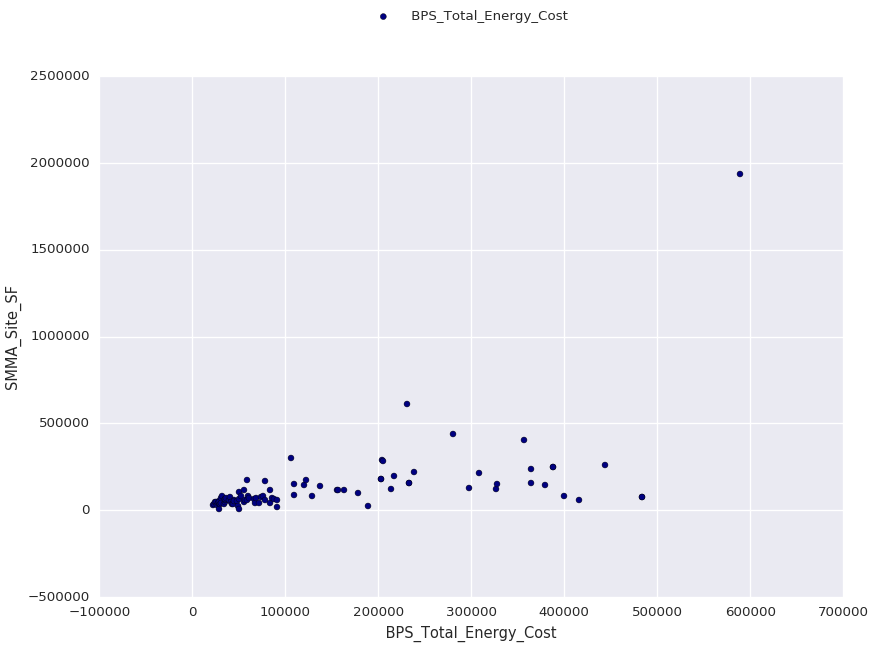

In [10]:
display(schools_df)

![iforest_energycost_sqft](https://user-images.githubusercontent.com/28162685/28127972-2ecf0362-66fc-11e7-9737-cf209289182f.png)

Continuing with square feet as one-dimension (to give a sense of where our last data points fell), look at what differentiated the outliers with normal square footage. A few schools with very high enrollment (1500+) were labeled as outliers.


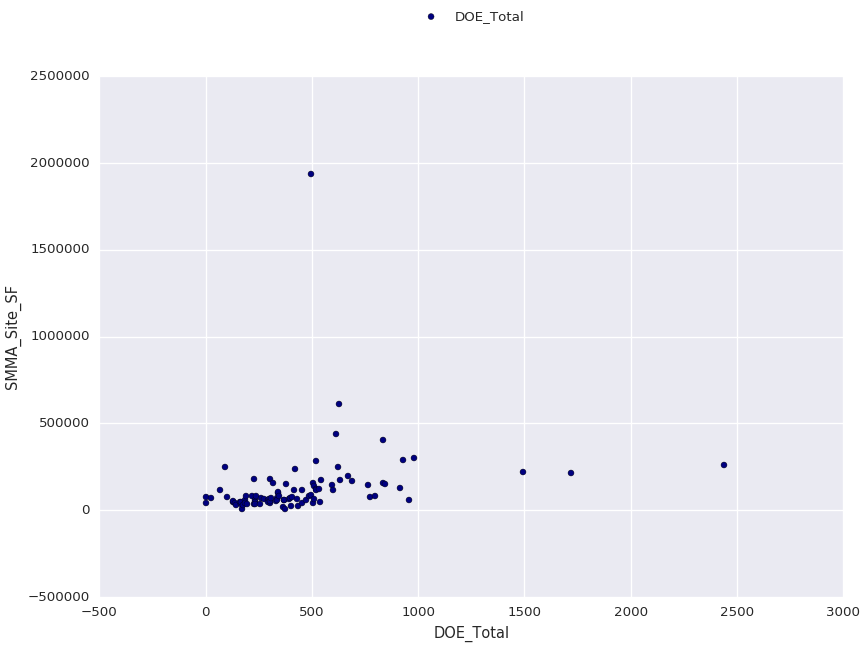

In [11]:
display(schools_df)

![iforest_enrollment_sqft](https://user-images.githubusercontent.com/28162685/28128007-43e35924-66fc-11e7-98a6-f8e849802b33.png)

Finally (and most helpfully), look at *Principal Earnings* against *Square feet*. Several principals have very low earnings. This may be because they joined the district at the beginning of the school year and only earned about half of a full year's salary. These data points would need to be removed or adjusted going forward.


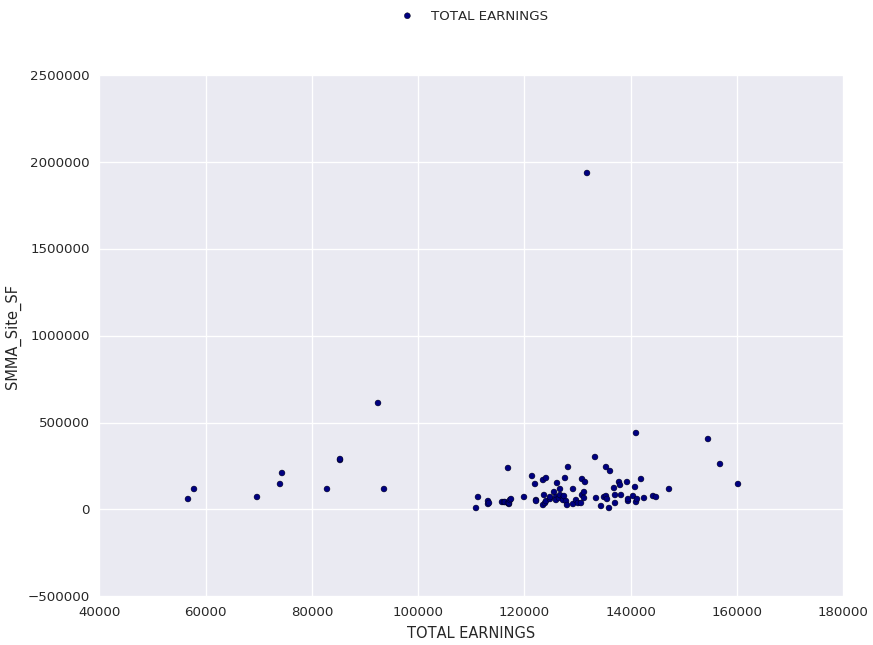

In [12]:
display(schools_df)

![iforest_earnings_sqft](https://user-images.githubusercontent.com/28162685/28127541-e90b4710-66fa-11e7-8bc3-edb43cca037a.png)

### One Class SVM

One Class SVM looks to be a poorer fit (or less well-tuned) for this data set. The graphs below show the outliers show no clear pattern.


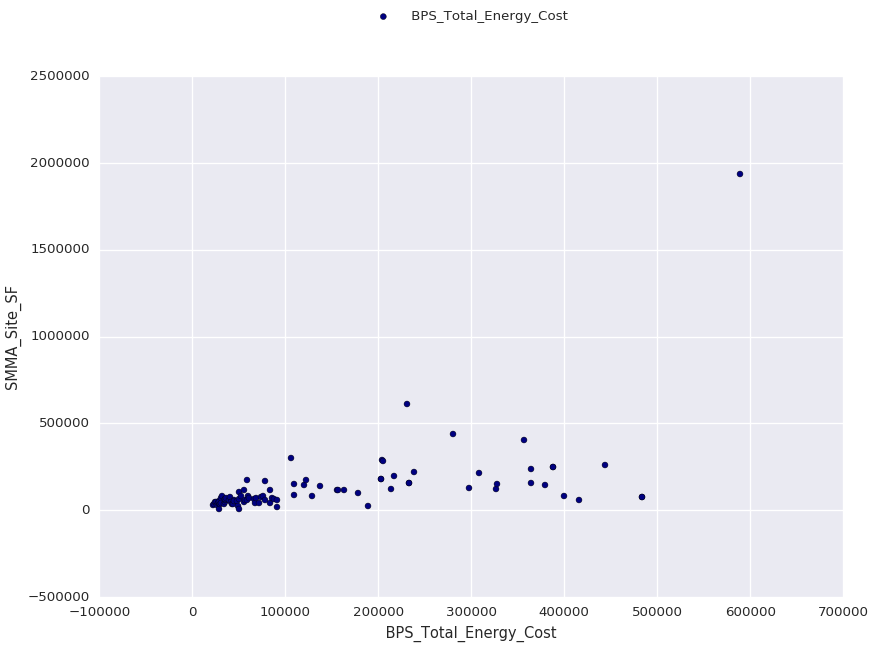

In [13]:
display(schools_df)

![svm_energycost_sqft](https://user-images.githubusercontent.com/28162685/28128108-a5fe2062-66fc-11e7-88eb-0515efc0a81e.png)
![svm_enrollment_sqft](https://user-images.githubusercontent.com/28162685/28128125-b4034fa2-66fc-11e7-8cbf-955d1085c820.png)
![svm_earnings_sqft](https://user-images.githubusercontent.com/28162685/28128087-8e358290-66fc-11e7-9b7f-e047bfdbbb7f.png)

## 6. Next steps<a class="anchor" id="nextsteps"></a>
Next, you could add more functionality for users in the outlier PixieApp, including some tuning options, more algorithms, and PixieDust Events to link the plots to the dataframe. 
You could also look at adjusting for the outliers and trying out algorithms to answer the questions laid out at the beginning of this notebook.

### Author

**Tanya Rudakeyvch** is a data scientist at IBM USA.

Copyright © IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.